In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

from hyperopt import fmin, tpe, hp, Trials,STATUS_OK, Trials
from sklearn.metrics import f1_score  

from typing import Any, Dict, Union
from pycaret.classification import *
import joblib

sns.set()

## Analyze events_data

In [17]:
events_data = pd.read_csv("events_data.csv")
events_data = events_data.drop_duplicates()
events_data.head()

,member_id,dt,event_type
0,31ed7cf0-52a9-4cf2-a1a5-b1033d81db5b,2016-07-10,usage
1,aace8c9c-152b-44c6-b4fc-ce6548bd4c7b,2016-07-10,usage
2,99468c06-729a-4745-8040-9643c422ebd1,2015-11-30,usage
3,77c54d85-f664-4966-91c3-bba99d36f01c,2015-11-30,usage
4,8d902e4c-8cae-44bb-84ed-70f1a39b84ec,2015-11-30,usage


In [18]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589704 entries, 0 to 1741497
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   member_id   1589704 non-null  object
 1   dt          1589704 non-null  object
 2   event_type  1589704 non-null  object
dtypes: object(3)
memory usage: 48.5+ MB


dt should be date type, member_id should be string

In [19]:
events_data['dt'] = pd.to_datetime(events_data['dt'])
events_data['member_id'] = events_data['member_id'].astype('str')  # Ensure data type is string

Applying OHE on event_type

In [20]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589704 entries, 0 to 1741497
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   member_id   1589704 non-null  object        
 1   dt          1589704 non-null  datetime64[ns]
 2   event_type  1589704 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 48.5+ MB


In [21]:
event_type_OHE = pd.get_dummies(events_data['event_type'])
events_data = events_data.drop(["event_type","dt"],axis = 1)
events_data[event_type_OHE.columns] = event_type_OHE
events_data.head()

,member_id,app_interaction,automated_email_sent,chat_message_sent,fitness_consultation,human_communication,manual_email_sent,personal_appointment_scheduled,pt_sale,pt_usage,sms_sent,usage
0,31ed7cf0-52a9-4cf2-a1a5-b1033d81db5b,0,0,0,0,0,0,0,0,0,0,1
1,aace8c9c-152b-44c6-b4fc-ce6548bd4c7b,0,0,0,0,0,0,0,0,0,0,1
2,99468c06-729a-4745-8040-9643c422ebd1,0,0,0,0,0,0,0,0,0,0,1
3,77c54d85-f664-4966-91c3-bba99d36f01c,0,0,0,0,0,0,0,0,0,0,1
4,8d902e4c-8cae-44bb-84ed-70f1a39b84ec,0,0,0,0,0,0,0,0,0,0,1


In [22]:
#Group by 'member_id' and sum the values in other columns
events_data_gb = events_data.groupby('member_id').sum().reset_index()

In [24]:
events_data_gb.head()

,member_id,app_interaction,automated_email_sent,chat_message_sent,fitness_consultation,human_communication,manual_email_sent,personal_appointment_scheduled,pt_sale,pt_usage,sms_sent,usage
0,00016556-2ff1-44c8-8e2a-6e11db51ff26,0,0,0,0,0,0,0,0,0,0,136
1,0006a9a9-129d-4c27-bb6d-d7dad35ad83d,0,0,0,0,0,0,0,0,0,0,22
2,000a41b7-4fb2-4e7b-850e-9b7a221434b0,0,0,0,0,0,0,0,0,0,0,348
3,000a856e-fd3b-424d-98bc-d19de84390a6,0,0,0,0,0,0,0,0,0,0,118
4,0013bc9a-bb31-4f42-911d-bd718442f380,11,0,0,0,0,0,1,0,0,0,1270


In [25]:
events_data_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9966 entries, 0 to 9965
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   member_id                       9966 non-null   object
 1   app_interaction                 9966 non-null   uint64
 2   automated_email_sent            9966 non-null   uint8 
 3   chat_message_sent               9966 non-null   uint64
 4   fitness_consultation            9966 non-null   uint8 
 5   human_communication             9966 non-null   uint64
 6   manual_email_sent               9966 non-null   uint8 
 7   personal_appointment_scheduled  9966 non-null   uint8 
 8   pt_sale                         9966 non-null   uint8 
 9   pt_usage                        9966 non-null   uint64
 10  sms_sent                        9966 non-null   uint8 
 11  usage                           9966 non-null   uint64
dtypes: object(1), uint64(5), uint8(6)
memory usage: 

In [26]:
events_data_gb.describe()

,app_interaction,automated_email_sent,chat_message_sent,fitness_consultation,human_communication,manual_email_sent,personal_appointment_scheduled,pt_sale,pt_usage,sms_sent,usage
count,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000
mean,13.698575,0.181116,2.943608,0.167068,5.053984,0.650712,8.199478,0.328818,3.989966,3.476319,120.823099
std,37.128359,0.879269,16.714384,0.803956,20.264624,4.951416,21.661927,2.211303,25.603396,15.209716,143.831493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.000000
75%,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,158.000000
max,804.000000,20.000000,361.000000,54.000000,711.000000,137.000000,227.000000,131.000000,863.000000,224.000000,1823.000000


## pt_sale = target

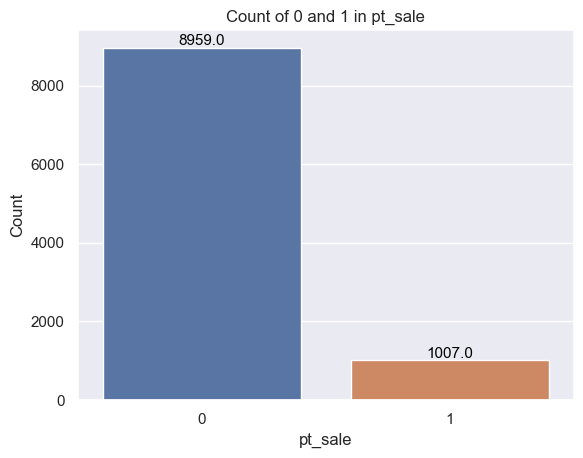

In [30]:
# Assuming df is your DataFrame and pt_sale is the column of interest
# Sample transformation of the 'usage' column
events_data_gb['pt_sale_category'] = events_data_gb['pt_sale'].apply(lambda x: 1 if x > 0 else 0)

ax = sns.countplot(x='pt_sale_category', data=events_data_gb)

plt.title('Count of 0 and 1 in pt_sale')
plt.xlabel('pt_sale')
plt.ylabel('Count')

# Loop through the bars and annotate the counts above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

pt_sale is completely unbalanced.
I will use severeal unbalacing methods after merging.

## Analyze subscribers_data

In [34]:
subscribers_data = pd.read_csv("subscribers_data.csv")
subscribers_data = subscribers_data.drop_duplicates()
subscribers_data.head()

,member_id,effective_date,segment_code,age,gender,country,district,city,subscription_type_code,subscription_status,weeks_from_last_activation,weeks_from_subscription_start,weeks_to_subscription_end
0,95b08d23-76cf-4f46-ae4a-7ff500aab5e1,2021-09-13,185265.0,61,F,us,AZ,CAVE CREEK,dues.cashterm,active,321,321,0.0
1,b6490675-a0cb-4e01-9952-dbba2deabb29,2021-09-13,185265.0,44,NaN,us,AZ,SCOTTSDALE,dues.open,active,113,113,NaN
2,781cf485-6e6b-4169-a4cc-c8b8c38279ba,2021-09-13,185474.0,29,M,us,LA,LAROSE,dues.open,active,139,139,NaN
3,edaa9f55-5496-4ad2-a6ce-5a9927920557,2021-09-13,185516.0,21,M,us,MA,MARLBOROUGH,dues.term,inactive,61,61,16.0
4,1a56c567-d57e-47d4-94c9-6866b495331a,2021-09-13,185632.0,26,F,us,TX,KATY,dues.term,active,7,7,70.0


In [35]:
subscribers_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260221 entries, 0 to 260220
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   member_id                      260221 non-null  object 
 1   effective_date                 260221 non-null  object 
 2   segment_code                   260218 non-null  float64
 3   age                            260221 non-null  int64  
 4   gender                         182332 non-null  object 
 5   country                        260221 non-null  object 
 6   district                       260221 non-null  object 
 7   city                           260073 non-null  object 
 8   subscription_type_code         260221 non-null  object 
 9   subscription_status            260221 non-null  object 
 10  weeks_from_last_activation     260221 non-null  int64  
 11  weeks_from_subscription_start  260221 non-null  int64  
 12  weeks_to_subscription_end     

### Member ID / Date

In [36]:
subscribers_data['member_id'] = subscribers_data['member_id'].astype('str')  # Ensure data type is string
subscribers_data['effective_date'] = pd.to_datetime(subscribers_data['effective_date'])  # Set 'effective_date' as data

### Gender

In [37]:
subscribers_data['gender'].value_counts(dropna=False)

M      116902
NaN     77889
F       65430
Name: gender, dtype: int64

in documentation Gender should have 3-4 values (Male , Female, Non-Binary, NA), but in the dataset we have only M,F and NA. In this case I can replace M with 0 and women with 1, all NaN should not be removed and I will create another column name "genderless" with 1 next to NaN, that will address all non-binary and others.

In [38]:
subscribers_data['gender'] = subscribers_data['gender'].replace({'M': 0, 'F': 1})
# Replace NaN values in the 'gender' column with -1
subscribers_data['gender'] = subscribers_data['gender'].fillna(-1)

### subscription_status

In [39]:
subscribers_data.subscription_status.value_counts(dropna=False)

active       209720
inactive      49098
suspended      1403
Name: subscription_status, dtype: int64

member can have an inactive club membership but still attend personal training, thus a suspended cannot. 
I will drop all suspended members and replace active with 1 and inactive with 0.

In [40]:
subscribers_data = subscribers_data[subscribers_data.subscription_status != "suspended"]
subscribers_data['subscription_status'] = subscribers_data['subscription_status'].replace({'active': 1, 'inactive': 0})

subscribers_data.subscription_status.value_counts(dropna=False)

1    209720
0     49098
Name: subscription_status, dtype: int64

### Age, activation and subscription columns

I will analyze all column's frequencies

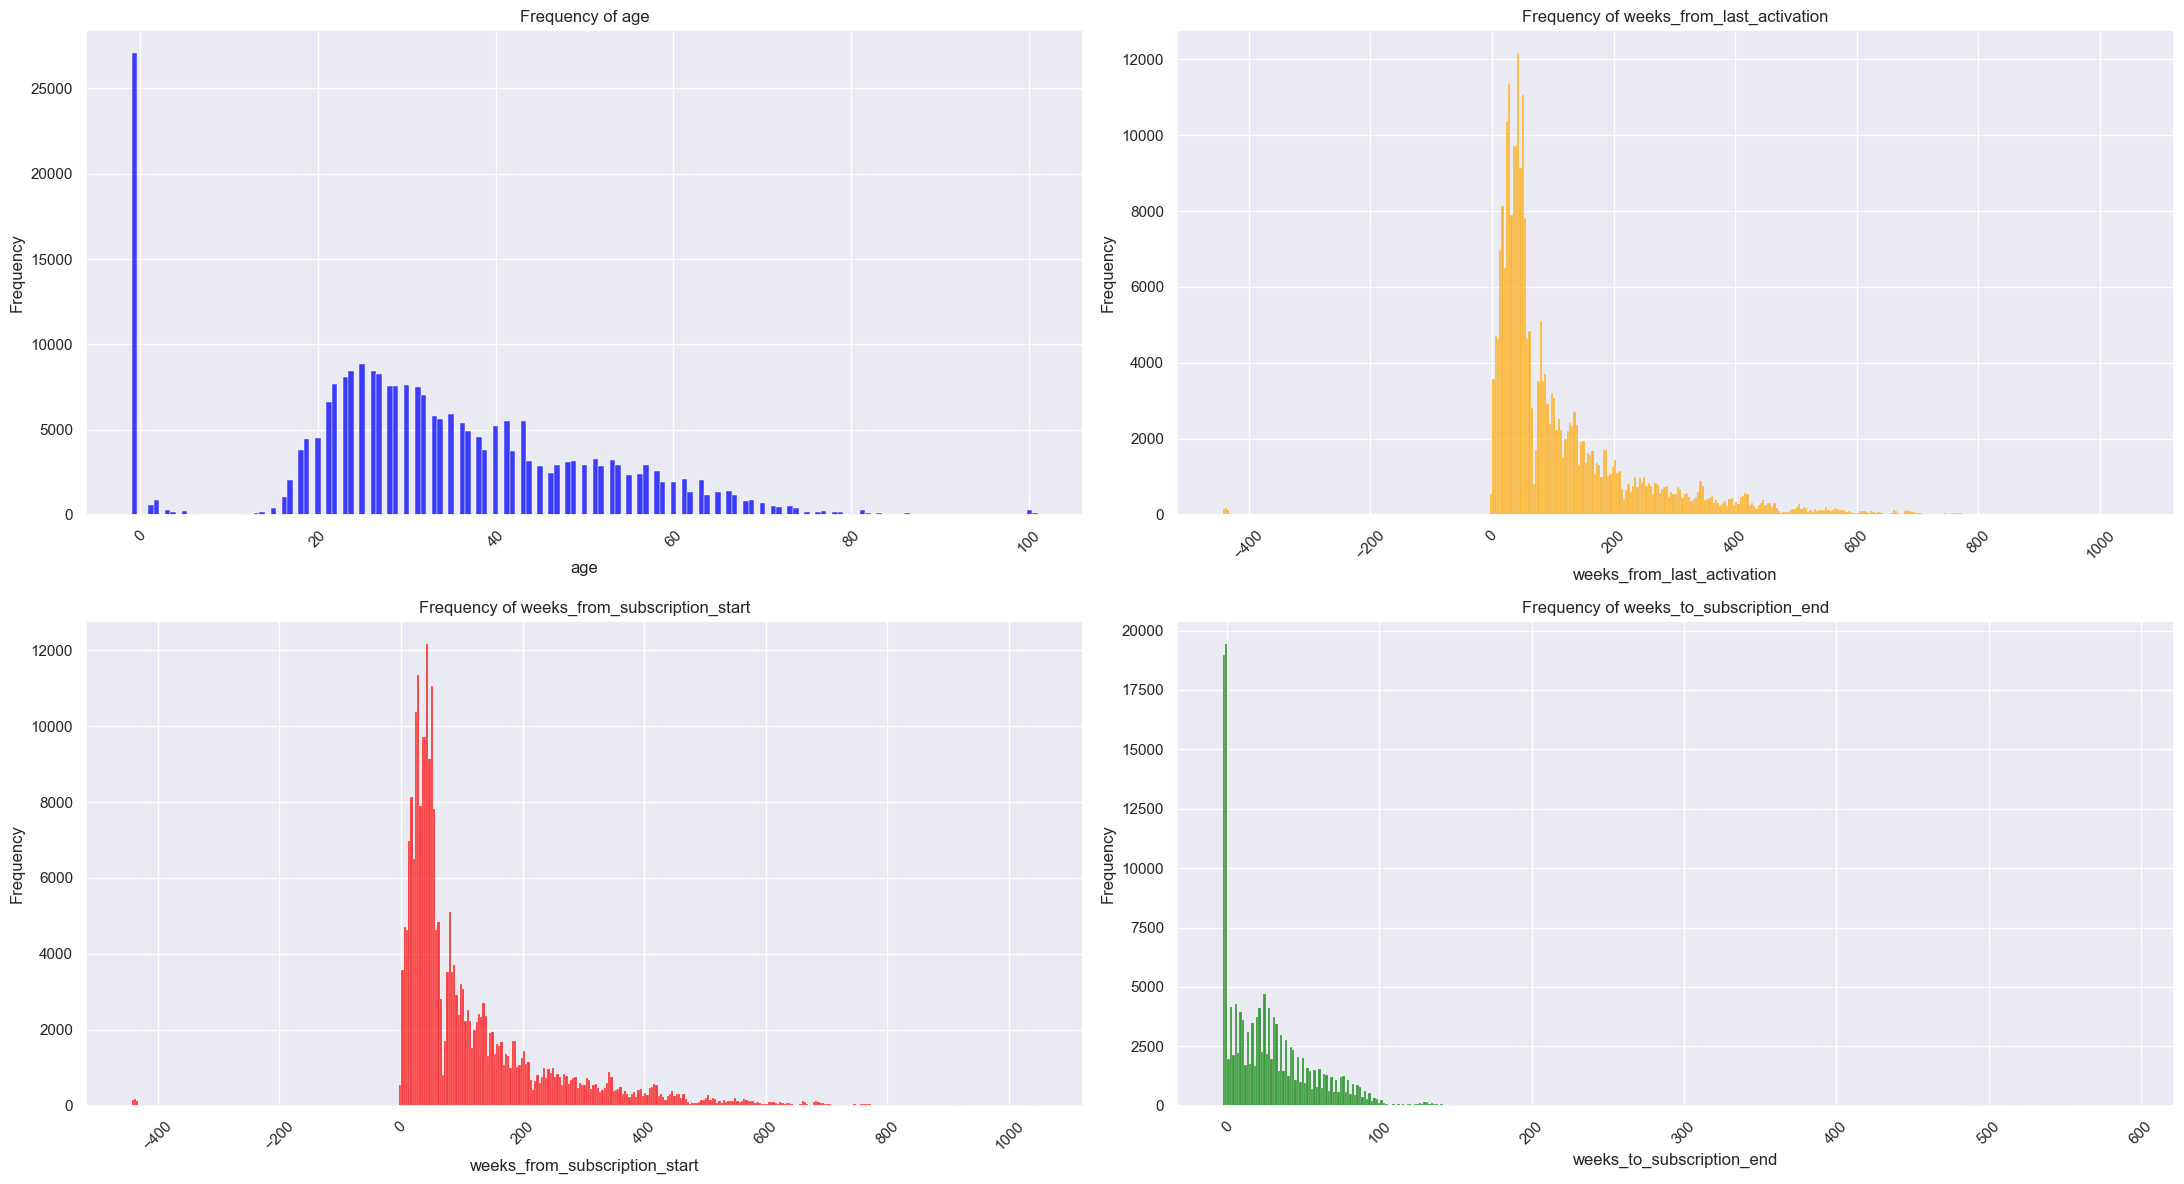

In [41]:
columns_plot = ["age", 'weeks_from_last_activation',
                'weeks_from_subscription_start',
                'weeks_to_subscription_end']
colors = ["blue", "orange", "red", "green"]  # Define colors for each plot
log_plot = 4*[(False, False)]

def plot_frequenc_cols(dataset,columns_plot,colors,log_plot,kde = False,condition_type = False,condition = None):

    fig, axes = plt.subplots(2, 2, figsize=(22, 12))

    axes_plot = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]

    for col, ax, color,log_p in zip(columns_plot, axes_plot, colors,log_plot):
        if not condition_type:
            sns.histplot(dataset[col], kde=kde,log_scale=log_p, ax=ax, color=color)
        else:
            sns.histplot(dataset[eval(condition)][col], kde=kde,log_scale=log_p, ax=ax, color=color)

        ax.set_title(f'Frequency of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)

    # Adjust the layout
    plt.tight_layout()
    plt.show()

plot_frequenc_cols(subscribers_data,columns_plot,colors,log_plot)

It seens there are a lot of negetive values - in age it means NaN, in other columns it is addressed differently.

I'll remove all negetive values and conclude

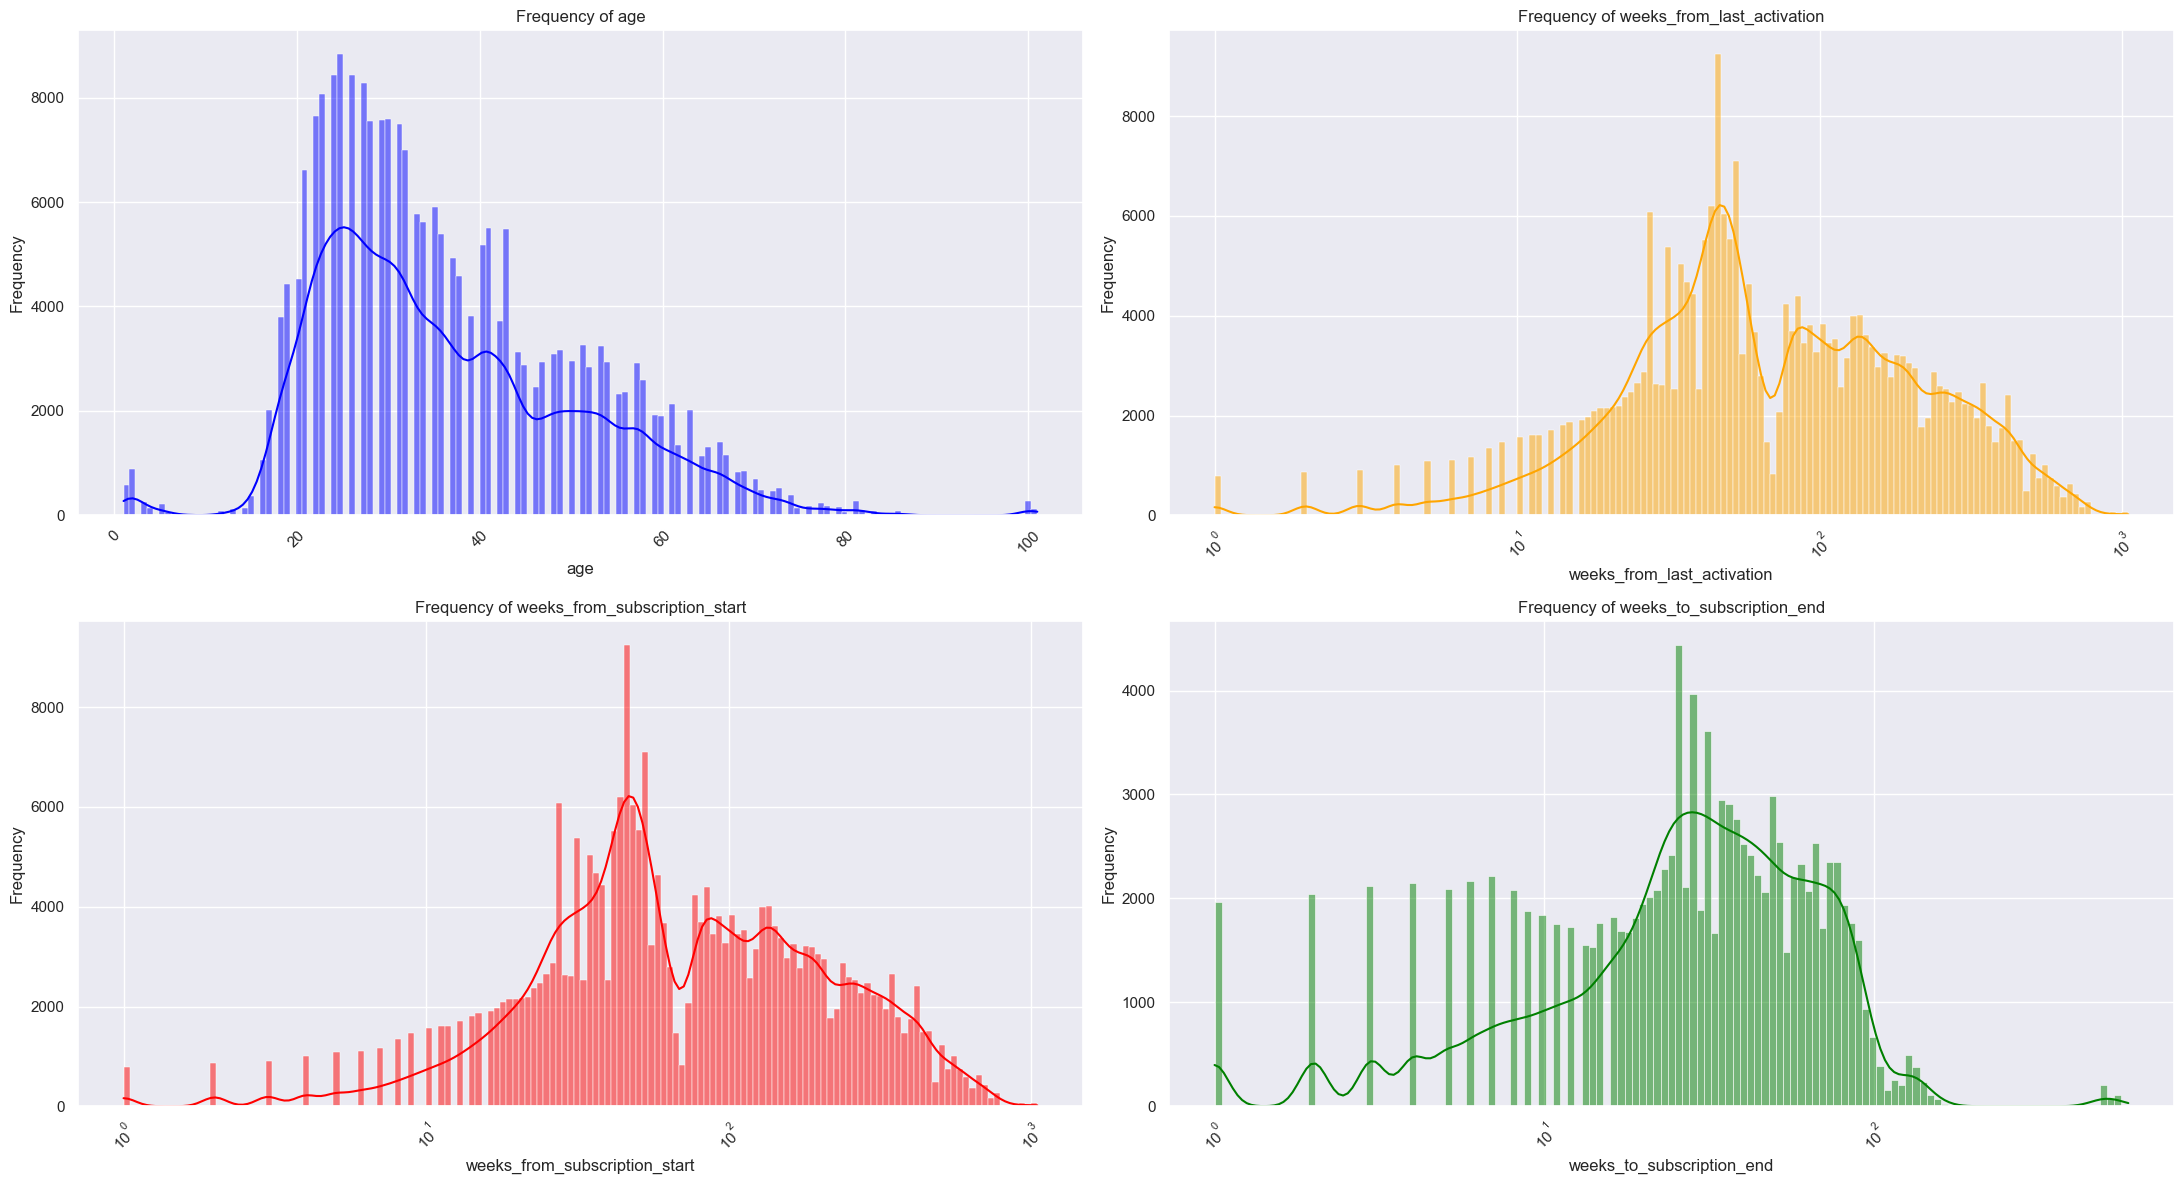

In [42]:
log_plot = [(False, False),(True, False),(True, False),(True, False)]
condition = "dataset[col] > 0"
plot_frequenc_cols(subscribers_data,columns_plot,colors,log_plot,kde = True,condition_type = True,condition = condition)

#### Frequency of Age

* The distribution of ages is not on a log scale and shows a bimodal pattern, indicating there are two age groups that are particularly common among the subscribers.
* The frequency tails off for older age groups


#### Frequency of Weeks from Subscription Start (Log Scale)

* There is a significant concentration of subscribers whose subscription started very recently, as indicated by the high frequency at the left end of the log-scaled axis.
* The sharp decline in frequency as we move right on the log scale suggests an exponential drop in the number of subscribers as the duration since subscription start increases, which is typical in a logarithmic distribution.

#### Frequency of Weeks from Last Activation (Log Scale)

* The high peak at the lower end of the log scale indicates a large number of subscribers have activated or re-activated their subscriptions in the recent past, with the number decreasing rapidly as time since last activation increases.
* The log scale emphasizes that while there are subscribers across a wide range of time since last activation, the majority are clustered towards the more recent end.

#### Frequency of Weeks to Subscription End (Log Scale)

* The peak seen on the left side of the log-scaled histogram suggests that a significant portion of subscriptions is approaching their end soon.
* The decrease in frequency towards the right end of the log scale indicates that there are progressively fewer subscribers with longer times until their subscription ends, with a small number of subscriptions spread out over a longer time scale.

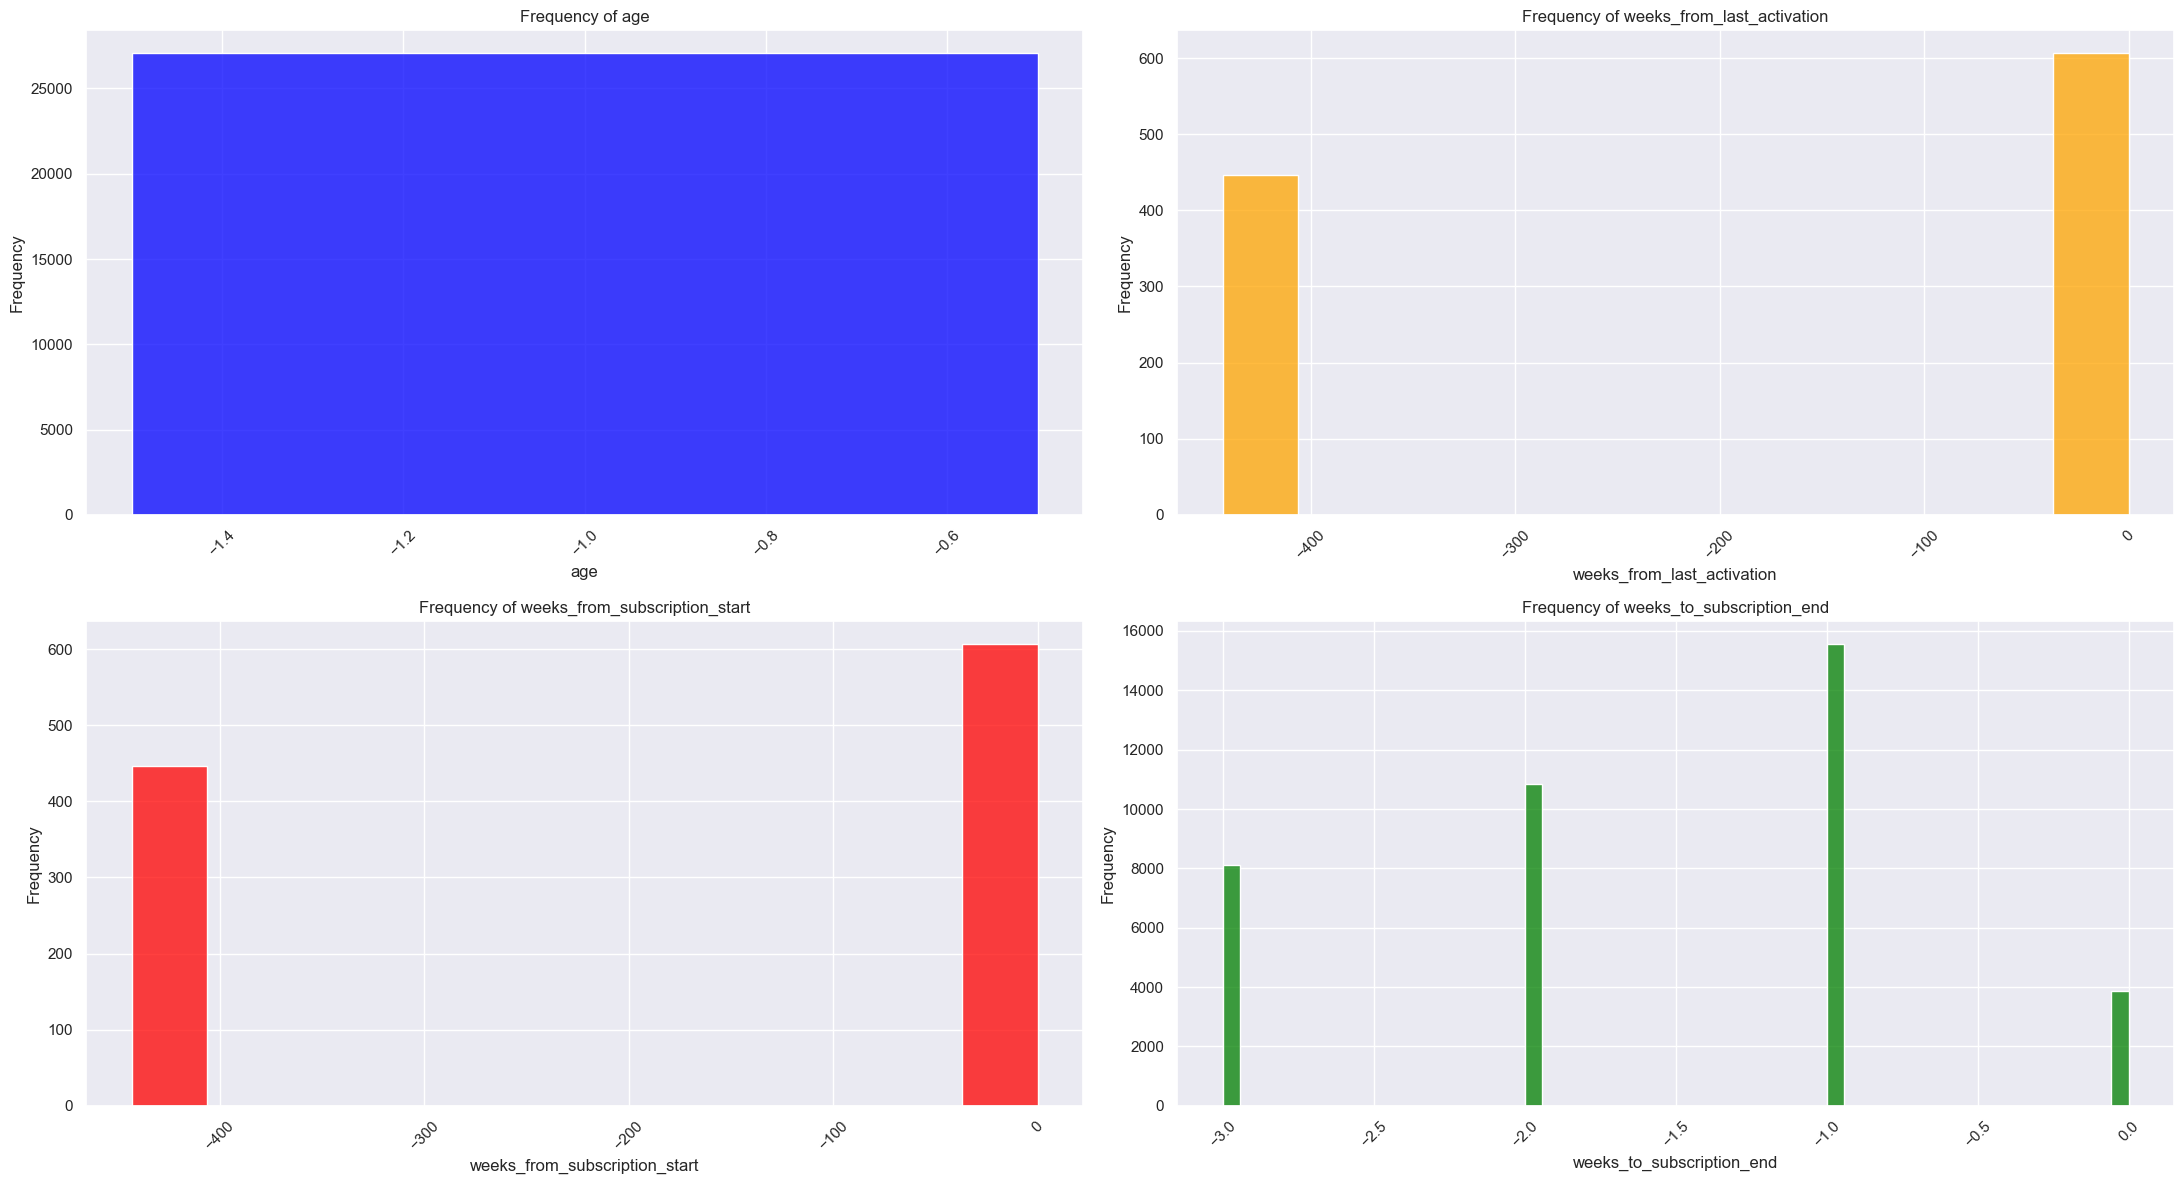

In [43]:
log_plot = 4*[(False, False)]
condition = "dataset[col] < 1"
plot_frequenc_cols(subscribers_data,columns_plot,colors,log_plot,condition_type = True,condition = condition)

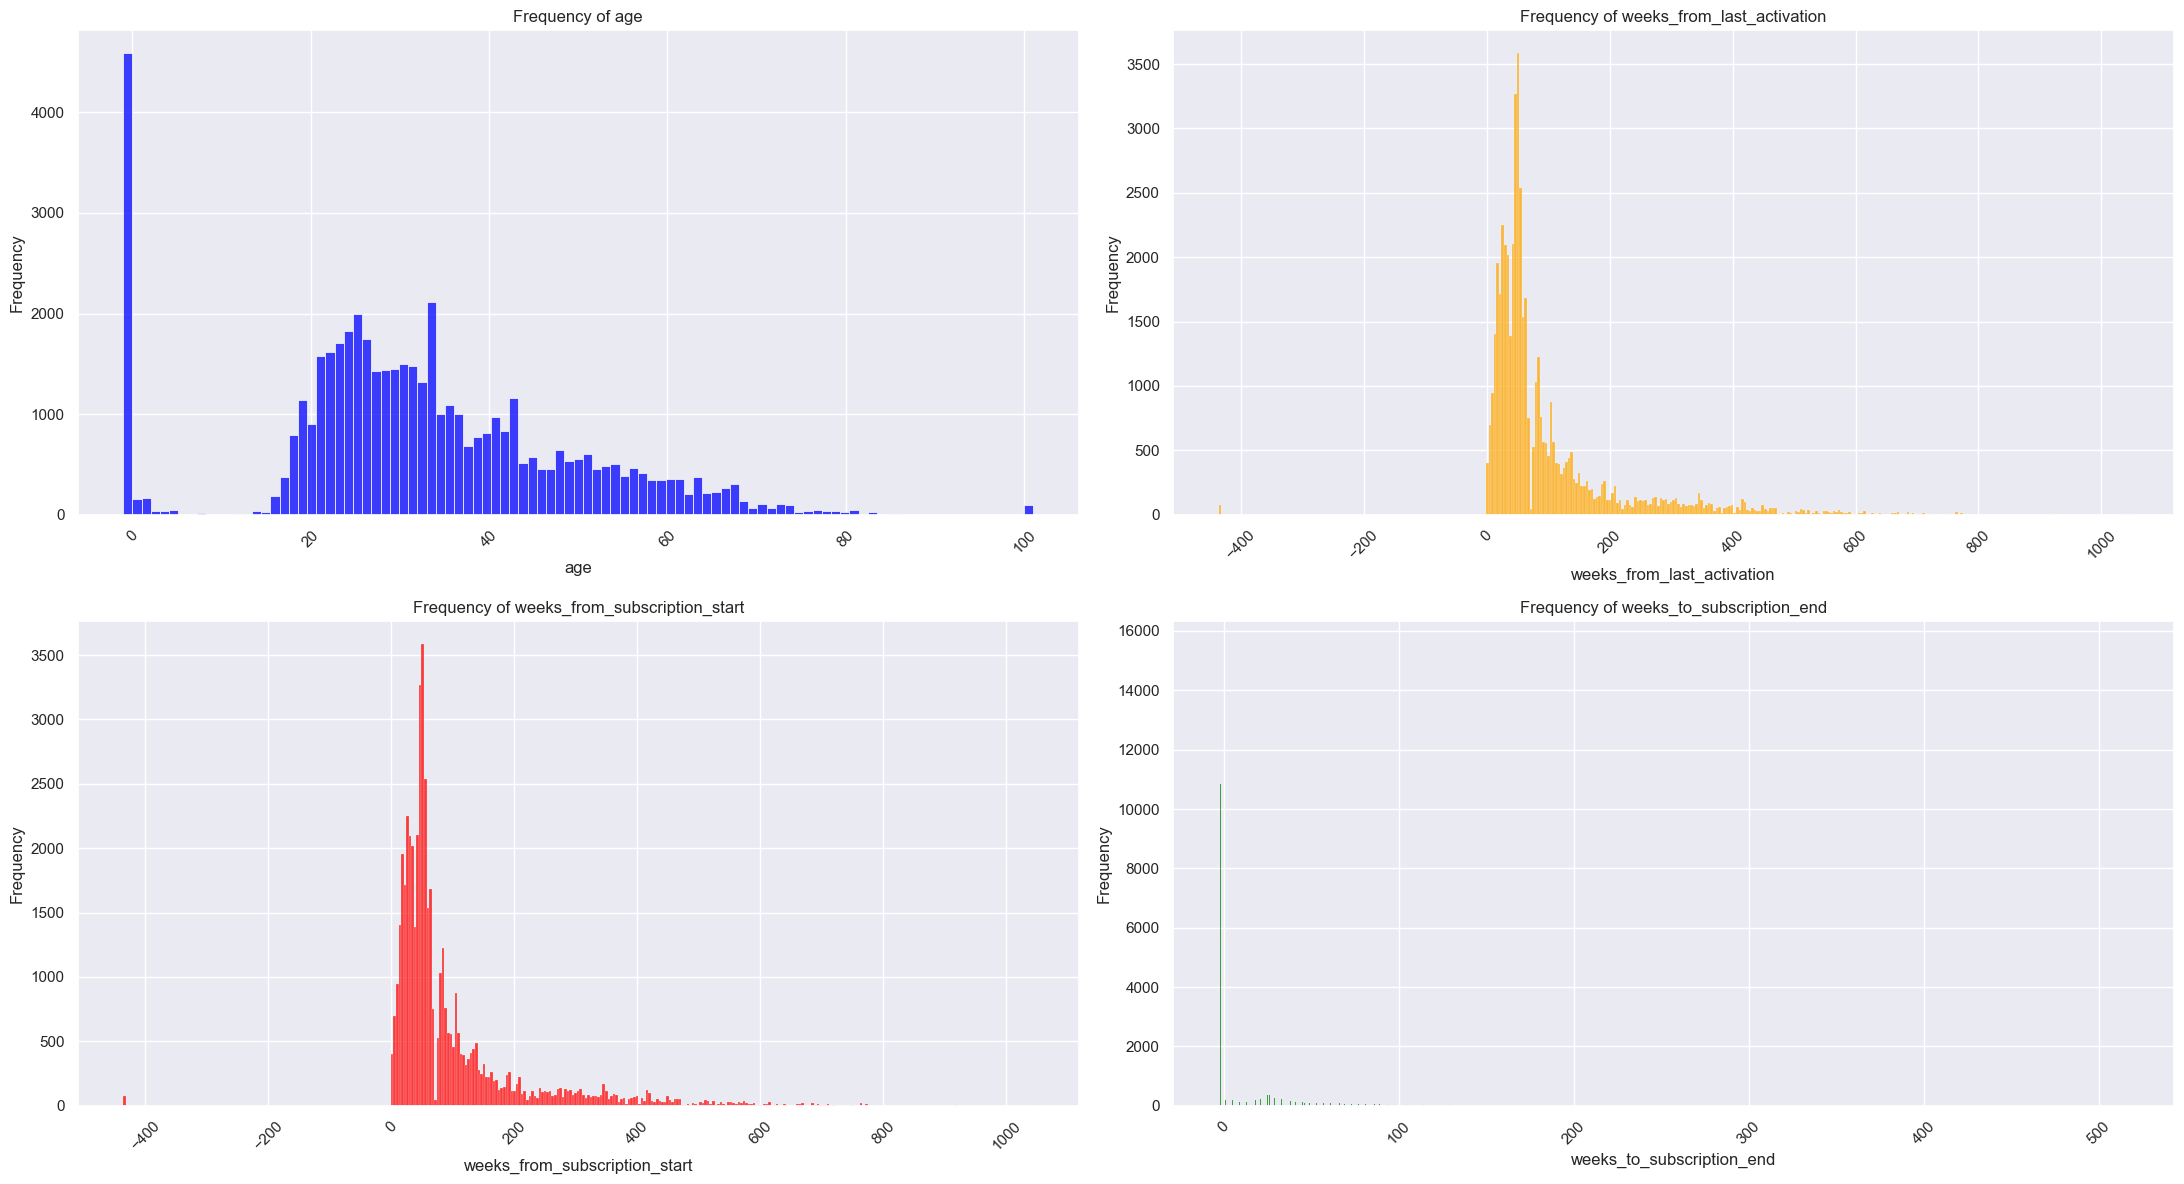

In [44]:
condition = "subscribers_data.subscription_status == 0"
plot_frequenc_cols(subscribers_data,columns_plot,colors,log_plot,condition_type = True,condition = condition)

all weeks columns should be positive, hence I'll remove all negetive values.

In [45]:
print(f' there are {round(100*subscribers_data.age.value_counts()[-1] /subscribers_data.age.value_counts().sum(),2)} % with no published age') 

 there are 10.45 % with no published age


since "age" columns shows a bimodal pattern, even ~11% will not have additional effect on results. Therefore, it can be dropped.

In [46]:
for col in columns_plot:
    subscribers_data = subscribers_data[subscribers_data[col] > 0]

In [47]:
subscribers_data.isnull().sum()

member_id                        0
effective_date                   0
segment_code                     1
age                              0
gender                           0
country                          0
district                         0
city                             0
subscription_type_code           0
subscription_status              0
weeks_from_last_activation       0
weeks_from_subscription_start    0
weeks_to_subscription_end        0
dtype: int64

one segment code will not make any difference

In [48]:
subscribers_data  = subscribers_data.dropna()

both tables should be merged on member_id

In [82]:
# Merge the DataFrames on 'Member_id'
df = pd.merge(events_data_gb, subscribers_data, on='member_id')

# Display the merged DataFrame
df.head()

,member_id,app_interaction,automated_email_sent,chat_message_sent,fitness_consultation,human_communication,manual_email_sent,personal_appointment_scheduled,pt_sale,pt_usage,...,age,gender,country,district,city,subscription_type_code,subscription_status,weeks_from_last_activation,weeks_from_subscription_start,weeks_to_subscription_end
0,00d1ea30-8d50-4f07-8254-ff98e36fbaa6,4,0,0,0,25,0,12,2,21,...,46,1.0,us,PA,SPRINGDALE,dues.term,0,18,18,85.0
1,00d1ea30-8d50-4f07-8254-ff98e36fbaa6,4,0,0,0,25,0,12,2,21,...,46,1.0,us,PA,SPRINGDALE,dues.term,0,18,18,85.0
2,00d1ea30-8d50-4f07-8254-ff98e36fbaa6,4,0,0,0,25,0,12,2,21,...,46,1.0,us,PA,SPRINGDALE,dues.term,1,16,16,87.0
3,00d1ea30-8d50-4f07-8254-ff98e36fbaa6,4,0,0,0,25,0,12,2,21,...,46,1.0,us,PA,SPRINGDALE,dues.term,0,18,18,85.0
4,00d1ea30-8d50-4f07-8254-ff98e36fbaa6,4,0,0,0,25,0,12,2,21,...,46,1.0,us,PA,SPRINGDALE,dues.term,1,17,17,87.0


In [83]:
replace_dict = {
    'dues.term': "term",
    'dues.cashterm': "cashterm",
    'dues.open': "open"
}

df['subscription_type_code'] = df['subscription_type_code'].replace(replace_dict)
# with a prefix 'subscription_type'
encoded_df = pd.get_dummies(df['subscription_type_code'], prefix='subscription_type')
# Concatenate the original DataFrame with the new one-hot encoded DataFrame
df[encoded_df.columns] = encoded_df
df = df.drop("subscription_type_code",axis = 1)

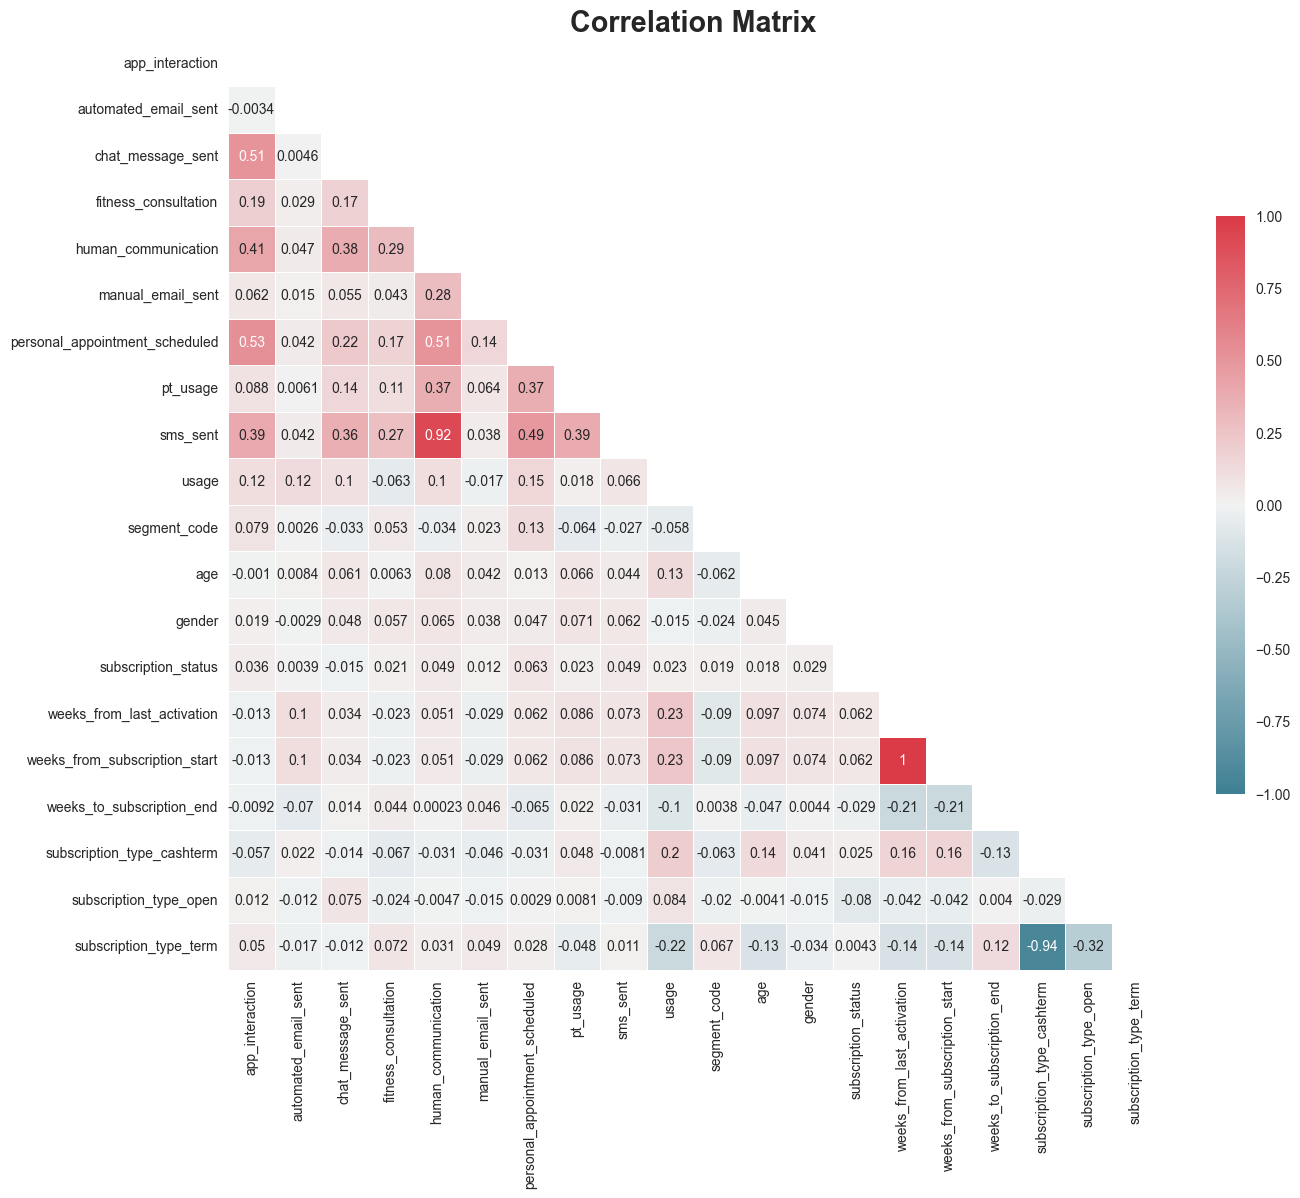

In [84]:
y = df.pt_sale_category
X = df.copy()
X = df.drop(['member_id',"pt_sale",'country', 'district', 'city',"pt_sale_category"],axis = 1)
#Put the target as last feature
cor = X.corr()
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(15, 15))
heatmap=sns.heatmap(cor,mask=mask,annot=True,annot_kws={"size": 10},
                    center=0,cmap=cmap,square=True, linewidths=.5,
                    cbar_kws={"shrink": .5},yticklabels=1,xticklabels=1,vmin=-1, vmax=1)
plt.title("Correlation Matrix", fontsize='xx-large', fontweight='bold')

plt.show()

There is a correlation between  Weeks_from_subscription_start and Weeks_from_last_activation , and last activation is always bigger than start. I will create new column that is the ratio between the two.

There is also hight correlation between cash term and term (both are term), therefore I'll combine between the two and then drop cashterm (duplicate) and open (the opposite of term)

sms_sent is highly correlated to human_communication_event - is may seems that sms_sent can be under human_communication_event, so I''ll add a feature chat_sms_ratio that is the chat messsages by all sms and chat messages.

In [88]:
df["start_activation_ratio"] = df["weeks_from_subscription_start"]/df["weeks_from_last_activation"]
df["chat_sms_ratio"] = df["chat_message_sent"]/(df["sms_sent"] + df["chat_message_sent"])
df["chat_sms_ratio"] = df["chat_sms_ratio"].fillna(0)
df["subscription_type_term"] = df.subscription_type_cashterm + df.subscription_type_term

df = df.drop(["weeks_from_last_activation","weeks_from_subscription_start",
              "subscription_type_cashterm","subscription_type_open","sms_sent","chat_message_sent"],axis = 1)

# Udersampling

In [90]:
# Separate features and target
X = df.drop('pt_sale_category', axis=1)  # Features
y = df['pt_sale_category']  # Target variable

# Initializing the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Applying the under-sampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Creating a new DataFrame from the resampled data
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['pt_sale_category'] = y_resampled

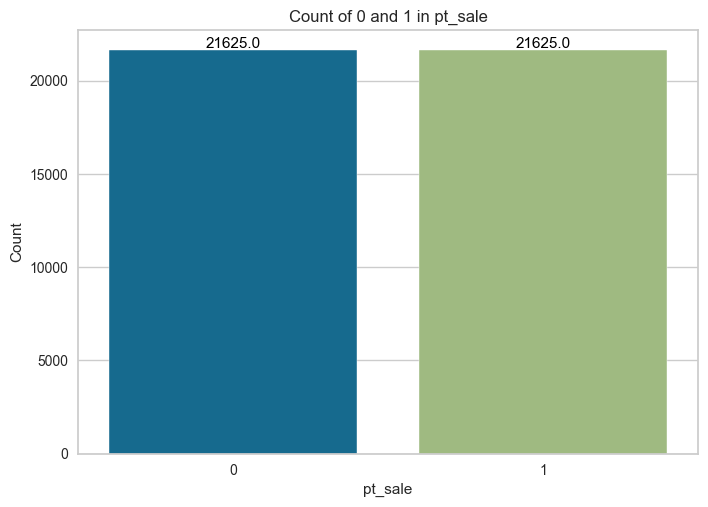

In [91]:
# Assuming df is your DataFrame and pt_sale is the column of interest
ax = sns.countplot(x='pt_sale_category', data=df_resampled)

plt.title('Count of 0 and 1 in pt_sale')
plt.xlabel('pt_sale')
plt.ylabel('Count')

# Loop through the bars and annotate the counts above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

I will drop all location columns which I think are not saying too much, also all id's (member, segment) and dates (this is classification model and not time series).


also Usage is negetive correlated to bunch of columns, hence I'll remove it too

In [92]:
df_resampled_clean = df_resampled.copy()
drop_cols = ['member_id','segment_code',
              'country', 'district', 'city',
              'pt_sale','effective_date']
df_resampled_clean = df_resampled.drop(drop_cols,axis = 1)

For initial model, I will drop non binary and NaN values

In [93]:
df_resampled_clean = df_resampled_clean[df_resampled_clean.gender != -1]

## AutoML

In [94]:
s = setup(data = df_resampled_clean, target = 'pt_sale_category', session_id=123)

,Description,Value
0,Session id,123
1,Target,pt_sale_category
2,Target type,Binary
3,Original data shape,"(28954, 16)"
4,Transformed data shape,"(28954, 16)"
5,Transformed train set shape,"(20267, 16)"
6,Transformed test set shape,"(8687, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [95]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:57:29
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,1.0000,1.0000,0.9999,1.0000,1.0000,0.9999,0.9999,0.9960
catboost,CatBoost Classifier,1.0000,1.0000,1.0000,0.9999,1.0000,0.9999,0.9999,13.1610
rf,Random Forest Classifier,0.9999,1.0000,1.0000,0.9997,0.9999,0.9997,0.9997,0.8560
xgboost,Extreme Gradient Boosting,0.9998,1.0000,1.0000,0.9995,0.9998,0.9995,0.9995,0.5410
dt,Decision Tree Classifier,0.9997,0.9997,1.0000,0.9994,0.9997,0.9994,0.9994,0.0490
lightgbm,Light Gradient Boosting Machine,0.9996,1.0000,1.0000,0.9992,0.9996,0.9992,0.9992,0.8140
knn,K Neighbors Classifier,0.9984,0.9996,0.9998,0.9971,0.9985,0.9968,0.9968,0.2330
gbc,Gradient Boosting Classifier,0.9636,0.9944,0.9559,0.9727,0.9642,0.9272,0.9273,1.9030
ada,Ada Boost Classifier,0.9184,0.9803,0.8954,0.9429,0.9185,0.8369,0.8381,0.5000
lr,Logistic Regression,0.8962,0.9558,0.8655,0.9276,0.8954,0.7926,0.7946,1.3080


In [96]:
tuned_best = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9299,0.9689,0.9020,0.9591,0.9297,0.8600,0.8616
1,0.9285,0.9755,0.9068,0.9516,0.9287,0.8570,0.8580
2,0.9260,0.9797,0.9001,0.9532,0.9259,0.8521,0.8535
3,0.9304,0.9708,0.8924,0.9697,0.9295,0.8611,0.8640
4,0.9393,0.9756,0.9222,0.9581,0.9398,0.8787,0.8793
5,0.9413,0.9754,0.9222,0.9619,0.9416,0.8826,0.8834
6,0.9334,0.9778,0.9107,0.9576,0.9335,0.8669,0.8680
7,0.9279,0.9714,0.9000,0.9571,0.9277,0.8560,0.8576
8,0.9353,0.9763,0.9067,0.9652,0.9351,0.8708,0.8725


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [121]:
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [97]:
y_pred_rf_tuned = predict_model(tuned_best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [98]:
def conf_matrix_show(y_pred,y_test):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 2,figsize=(12, 8))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues',ax=axes[0])
    disp.ax_.set_title("Confusion Matrix - Accuracy #")
    cm = 100*confusion_matrix(y_test, y_pred,normalize = "pred")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues',ax=axes[1])
    disp.ax_.set_title("Confusion Matrix - Accuracy %")

    print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4226
           1       1.00      1.00      1.00      4461

    accuracy                           1.00      8687
   macro avg       1.00      1.00      1.00      8687
weighted avg       1.00      1.00      1.00      8687



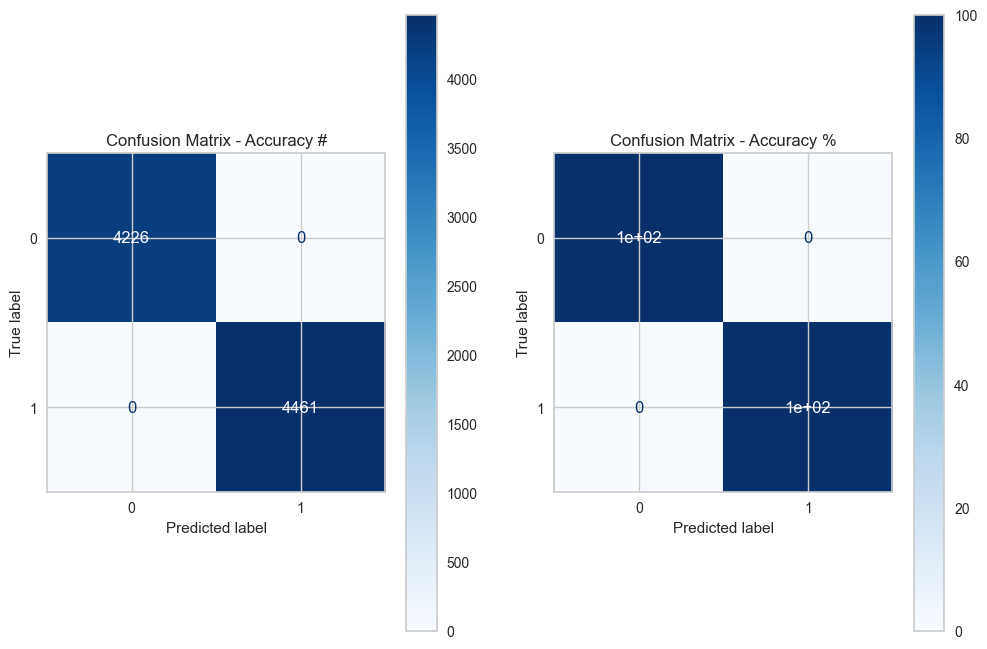

In [101]:
conf_matrix_show(y_pred_rf_tuned.prediction_label,y_pred_rf_tuned.pt_sale_category)

## XGBoost

has built-in capabilities to handle imbalanced datasets, using scal_pos_wight

In [104]:
# Splitting the dataset into training and testing sets
y = df_resampled_clean.pt_sale_category
X = df_resampled_clean.drop("pt_sale_category",axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## XGBOOST hypertuned with RandomUnderSampler

In [105]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]], 
                    X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series, 
                    early_stopping_rounds: int=100,
                    metric:callable = f1_score) -> Dict[str, Any]:

    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation, 
              verbose=False)    
         
    pred = model.predict(X_test)
    score = metric(y_test, pred,average = "weighted")
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

params = {'random_state': 42, 'eval_metric':'logloss'}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 8 , 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
#          {'scale_pos_weight':[1,2,4,10,20,50,100]}, # imbalanced
           {'max_delta_step':hp.uniform('max_delta_step', 0, 10)},
          {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
          {'reg_alpha': hp.uniform('reg_alpha', 0, 10)},
            {'reg_lambda': hp.uniform('reg_lambda', 1, 10)},
          {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
          {'learning_rate': hp.loguniform('learning_rate', -4, 0)}, # boosting,
]

all_trials = []
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, 
                                        y_train, X_test, y_test),            
        space=params,           
        algo=tpe.suggest,            
        max_evals=10,            
        trials=trials,
    )
    params = {**params, **best}
    all_trials.append(trials)

100%|██████████| 10/10 [00:14<00:00,  1.45s/trial, best loss: -0.999447429852403]


In [106]:
params["max_depth"] = int(params["max_depth"])
params

{'random_state': 42,
 'eval_metric': 'logloss',
 'max_depth': 4,
 'min_child_weight': 0.3221782246417759,
 'max_delta_step': 3.9486319990619,
 'subsample': 0.8500172133957289,
 'colsample_bytree': 0.7440642896057326,
 'reg_alpha': 0.3211546960560363,
 'reg_lambda': 1.0108426136649626,
 'gamma': 8.130506069330776e-05,
 'learning_rate': 0.5855657937584754}

In [110]:
xg_step = XGBClassifier(**params,  n_estimators=200)
xg_step.fit(X_train, y_train, eval_set=[(X_train, y_train),
                                        (X_test, y_test)], 
           verbose=100)
xg_step.score(X_test, y_test)

[0]	validation_0-logloss:0.39384	validation_1-logloss:0.39701
[100]	validation_0-logloss:0.00130	validation_1-logloss:0.00524
[199]	validation_0-logloss:0.00064	validation_1-logloss:0.00471


0.9995855781185247

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3528
           1       1.00      1.00      1.00      3711

    accuracy                           1.00      7239
   macro avg       1.00      1.00      1.00      7239
weighted avg       1.00      1.00      1.00      7239



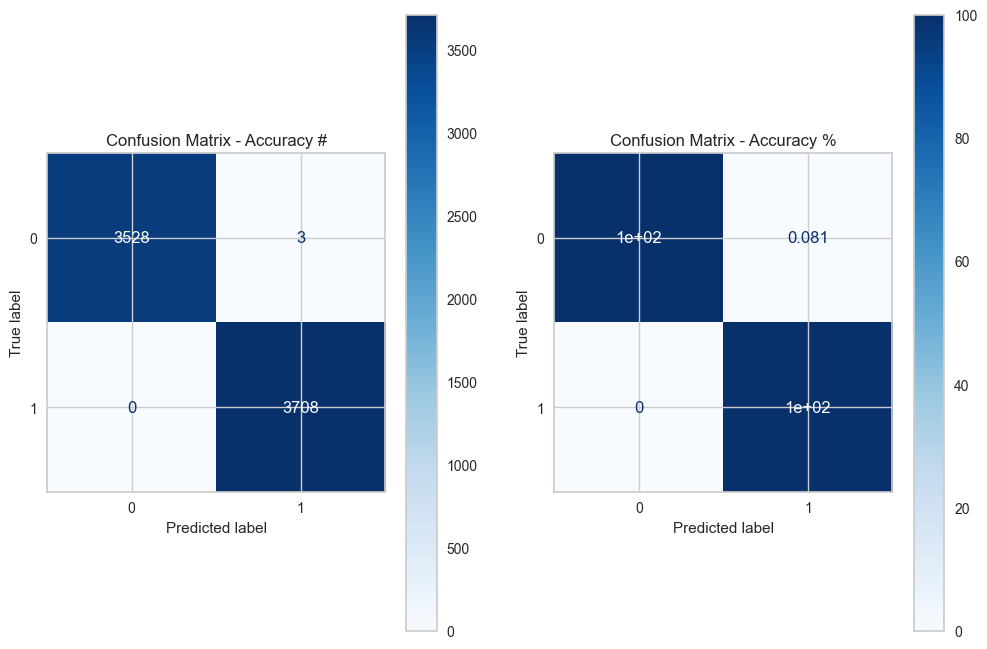

In [111]:
y_pred_xgb_tuned = xg_step.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb_tuned)

fig, axes = plt.subplots(1, 2,figsize=(12, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',ax=axes[0])
disp.ax_.set_title("Confusion Matrix - Accuracy #")
cm = 100*confusion_matrix(y_test, y_pred_xgb_tuned,normalize = "pred")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',ax=axes[1])
disp.ax_.set_title("Confusion Matrix - Accuracy %")

print(classification_report(y_pred_xgb_tuned,y_test))

<AxesSubplot: >

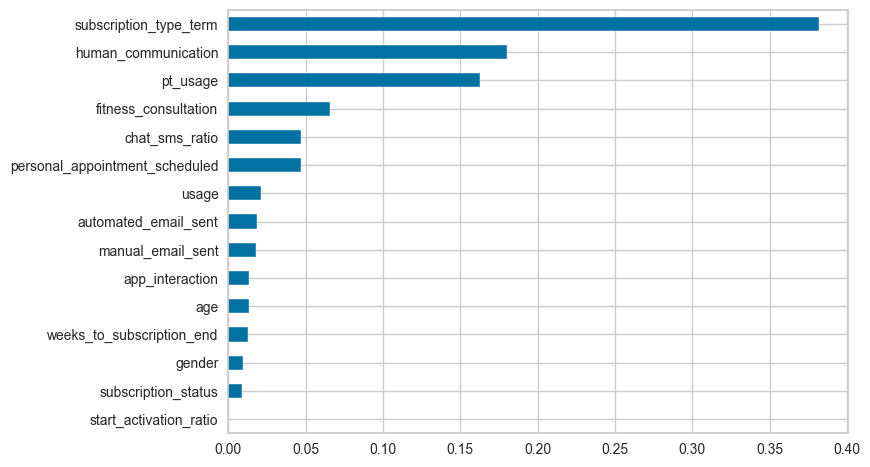

In [112]:
(pd.Series(xg_step.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh()
)

it seems that start_activation_ratio does not active in the model.

age and gender are at the bottom and they are most likely will have nan values in future.

subscription_type_term is too high, maybe it causes a bias.

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:08<00:00,  1.12trial/s, best loss: -0.9987567127521406]
[0]	validation_0-logloss:0.34126	validation_1-logloss:0.34359
[100]	validation_0-logloss:0.00753	validation_1-logloss:0.01212
[199]	validation_0-logloss:0.00574	validation_1-logloss:0.01004
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3525
           1       1.00      1.00      1.00      3714

    accuracy                           1.00      7239
   macro avg       1.00      1.00      1.00      7239
weighted avg       1.00      1.00      1.00      7239



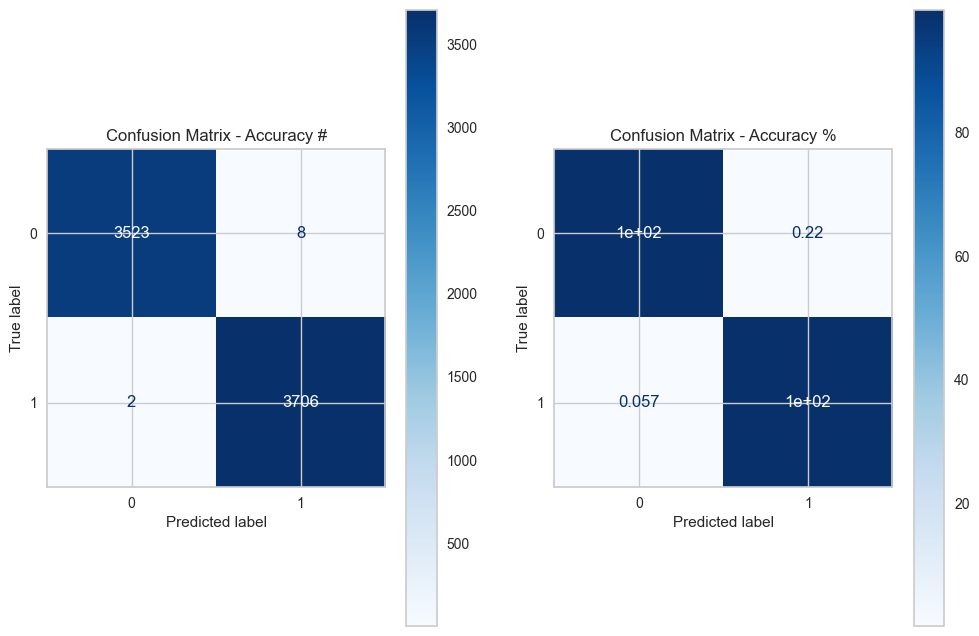

In [123]:
X = df_resampled_clean.drop(["pt_sale_category","start_activation_ratio","gender","age","subscription_type_term"],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

all_trials = []
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, 
                                        y_train, X_test, y_test),            
        space=params,           
        algo=tpe.suggest,            
        max_evals=10,            
        trials=trials,
    )
    params = {**params, **best}
    all_trials.append(trials)

params["max_depth"] = int(params["max_depth"])
xg_step = XGBClassifier(**params,  n_estimators=200)
xg_step.fit(X_train, y_train, eval_set=[(X_train, y_train),
                                        (X_test, y_test)], 
           verbose=100)
xg_step.score(X_test, y_test)

y_pred_xgb_tuned = xg_step.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb_tuned)

fig, axes = plt.subplots(1, 2,figsize=(12, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',ax=axes[0])
disp.ax_.set_title("Confusion Matrix - Accuracy #")
cm = 100*confusion_matrix(y_test, y_pred_xgb_tuned,normalize = "pred")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',ax=axes[1])
disp.ax_.set_title("Confusion Matrix - Accuracy %")

print(classification_report(y_pred_xgb_tuned,y_test))

<AxesSubplot: >

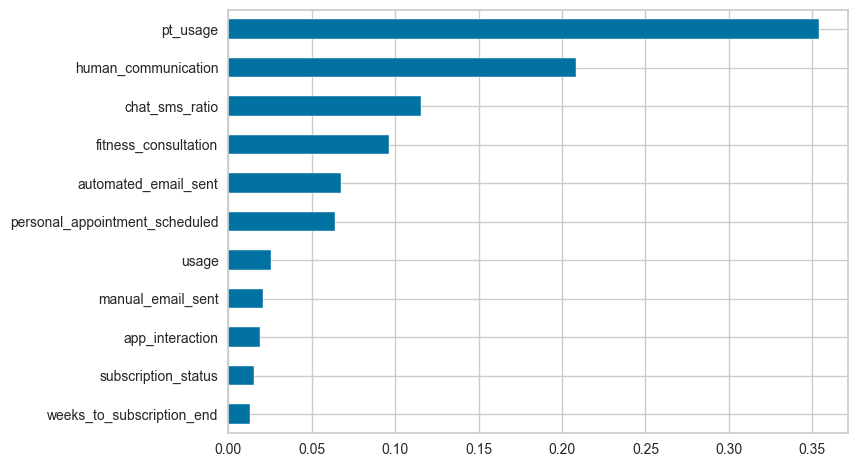

In [124]:
(pd.Series(xg_step.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh()
)

This model is much more even in feature importance and results barely dropped

If I'll drop 'subscription_status', 'weeks_to_subscription_end' then I won't have any dependency in Subscribers data. 

100%|██████████| 10/10 [00:10<00:00,  1.01s/trial, best loss: -0.9995855738453772]
[0]	validation_0-logloss:0.41100	validation_1-logloss:0.41466
[100]	validation_0-logloss:0.00183	validation_1-logloss:0.00564
[199]	validation_0-logloss:0.00121	validation_1-logloss:0.00527
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3528
           1       1.00      1.00      1.00      3711

    accuracy                           1.00      7239
   macro avg       1.00      1.00      1.00      7239
weighted avg       1.00      1.00      1.00      7239



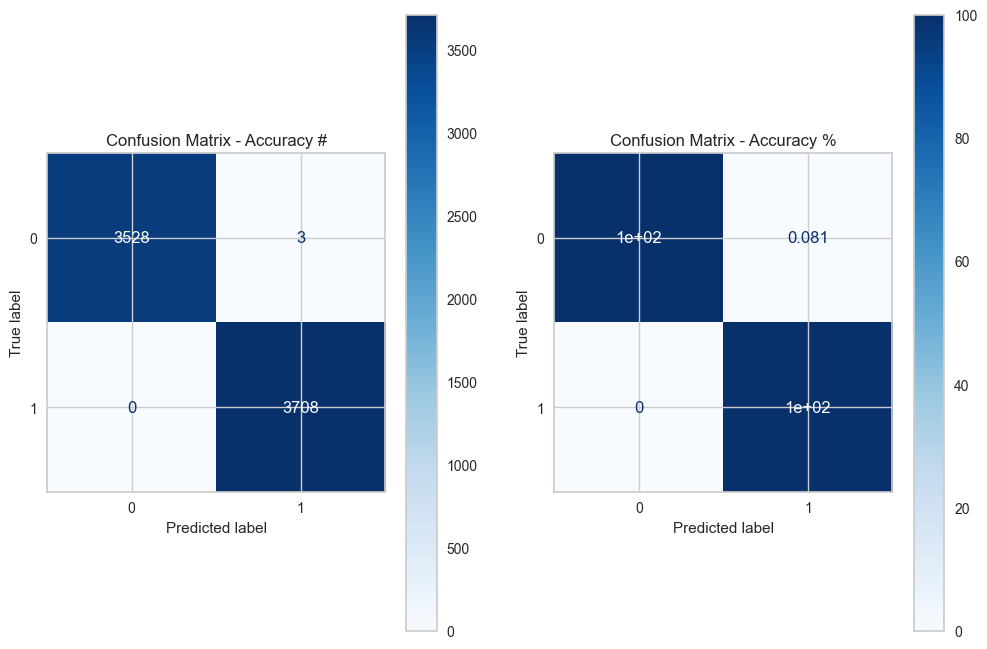

In [131]:
X = df_resampled_clean.drop(["pt_sale_category","start_activation_ratio",
                             "gender","age","subscription_type_term",
                             'subscription_status', 'weeks_to_subscription_end'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

all_trials = []
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, 
                                        y_train, X_test, y_test),            
        space=params,           
        algo=tpe.suggest,            
        max_evals=10,            
        trials=trials,
    )
    params = {**params, **best}
    all_trials.append(trials)

params["max_depth"] = int(params["max_depth"])
xg_step = XGBClassifier(**params,  n_estimators=200)
xg_step.fit(X_train, y_train, eval_set=[(X_train, y_train),
                                        (X_test, y_test)], 
           verbose=100)
xg_step.score(X_test, y_test)

y_pred_xgb_tuned = xg_step.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb_tuned)

fig, axes = plt.subplots(1, 2,figsize=(12, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',ax=axes[0])
disp.ax_.set_title("Confusion Matrix - Accuracy #")
cm = 100*confusion_matrix(y_test, y_pred_xgb_tuned,normalize = "pred")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',ax=axes[1])
disp.ax_.set_title("Confusion Matrix - Accuracy %")

print(classification_report(y_pred_xgb_tuned,y_test))

<AxesSubplot: >

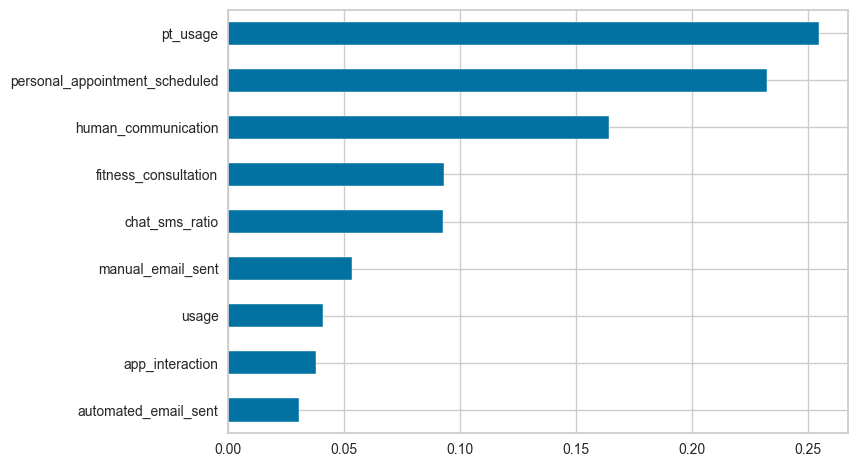

In [132]:
(pd.Series(xg_step.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh()
)

As I thought, not only I don't need Subscribers data, the model is even better without it

In [133]:
model_filename = 'Model.pkl'
joblib.dump(xg_step, model_filename)

['Model.pkl']

# Inference

In [154]:
max_preds = 10  #tunable

events_data_new = pd.read_csv("events_data.csv")
events_data_new = events_data_new.drop_duplicates()

subscribers_data = pd.read_csv("subscribers_data.csv")
subscribers_data = subscribers_data.drop_duplicates()

model = joblib.load('Model.pkl')

events_data_new['member_id'] = events_data_new['member_id'].astype('str')  # Ensure data type is string
event_type_OHE = pd.get_dummies(events_data_new['event_type'])
events_data_new = events_data_new.drop(["event_type","dt"],axis = 1)
events_data_new[event_type_OHE.columns] = event_type_OHE
events_data_new_gb = events_data_new.groupby('member_id').sum().reset_index()
events_data_new_gb['pt_sale_category'] = events_data_new_gb['pt_sale'].apply(lambda x: 1 if x > 0 else 0)

events_data_new_gb["chat_sms_ratio"] = events_data_new_gb["chat_message_sent"]/(events_data_new_gb["sms_sent"] + events_data_new_gb["chat_message_sent"])
events_data_new_gb["chat_sms_ratio"] = events_data_new_gb["chat_sms_ratio"].fillna(0)

cols = ['app_interaction', 'automated_email_sent', 'fitness_consultation',
       'human_communication', 'manual_email_sent',
       'personal_appointment_scheduled', 'pt_usage', 'usage',
       'chat_sms_ratio']

predictions = model.predict(events_data_new_gb[cols])
events_data_new_gb["pt_sale_pred"] = predictions

merged_df = pd.merge(events_data_new_gb, subscribers_data[['member_id', 'segment_code']], on='member_id', how='left')
filtered_df = merged_df[merged_df['pt_sale_pred'] == 1]
grouped_df = filtered_df.groupby('segment_code')['member_id'].apply(list).reset_index()
grouped_df['member_id'] = grouped_df['member_id'].apply(lambda x: x[:max_preds])
grouped_df['total pt_sale members'] = grouped_df['member_id'].apply(len)

In [155]:
grouped_df.head()

,segment_code,member_id,total pt_sale members
0,113.0,"[dc64b40e-2226-4b31-b364-66fea12d6285, dc64b40...",10
1,117.0,"[95fff5d2-df40-4785-9d4a-2e9279a892b0, 95fff5d...",10
2,126.0,"[3cbae3c9-1492-4dc6-b8c1-c35deb5a0c2c, 3cbae3c...",10
3,163.0,"[b5613c66-46f5-402e-913a-65d27b91babb, b5613c6...",10
4,167.0,"[24bd3388-e8ac-40db-a02b-d59b7242a16b, 24bd338...",10


<AxesSubplot: xlabel='total pt_sale members', ylabel='Count'>

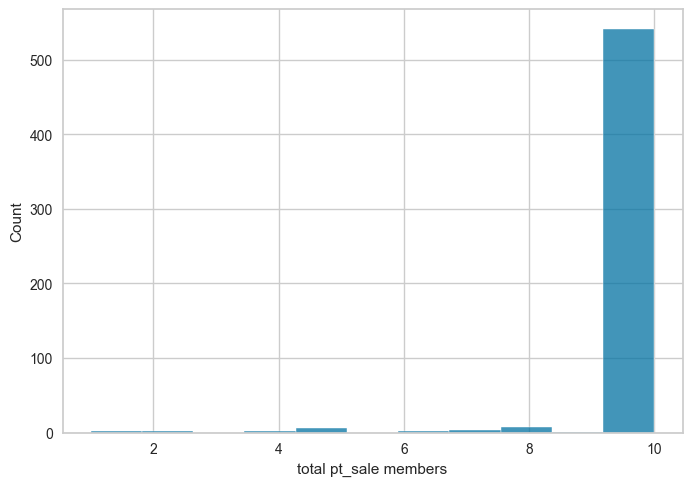

In [153]:
sns.histplot(grouped_df["total pt_sale members"])